## Описание работы перцептрона:
Архитектура: Входной слой → Скрытый слой (ReLU) → Выходной слой (Softmax)

Прямой проход:
- Данные проходят через взвешенные суммы и функции активации
- Преобразуются в вероятности классов через softmax

Обратное распространение:
- Вычисляются градиенты ошибки относительно всех параметров
- Используется цепное правило для распространения ошибки назад

Обучение:
- Градиентный спуск обновляет веса в направлении уменьшения ошибки
- Кросс-энтропия используется как функция потерь для многоклассовой классификации

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.datasets import make_blobs

class TwoLayerLinearPerceptron:
    def __init__(self, hidden_units=4, learning_rate=0.1, max_epochs=1000):
        # Архитектура сети и гиперпараметры
        self.hidden_units = hidden_units  # Количество нейронов в скрытом слое
        self.learning_rate = learning_rate  # Скорость обучения для градиентного спуска
        self.max_epochs = max_epochs  # Максимальное количество эпох обучения
        
        # Параметры модели (веса и смещения)
        self.W1 = None  # Матрица весов между входным и скрытым слоем
        self.b1 = None  # Вектор смещений для скрытого слоя
        self.W2 = None  # Матрица весов между скрытым и выходным слоем
        self.b2 = None  # Вектор смещений для выходного слоя
        
        # История обучения для визуализации
        self.loss_history = []  # Список для отслеживания потерь на каждой эпохе
        
    def _relu(self, x):
        """ReLU функция активации - возвращает максимум между 0 и входным значением"""
        return np.maximum(0, x)
    
    def _relu_derivative(self, x):
        """Производная ReLU - 1 для положительных значений, 0 для отрицательных"""
        return (x > 0).astype(float)
    
    def _softmax(self, x):
        """Функция softmax для многоклассовой классификации - преобразует выходы в вероятности"""
        # Стабилизация вычислений путем вычитания максимума
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)
    
    def initialize_weights(self, input_size, output_size):
        """Инициализация весов небольшими случайными значениями"""
        # Инициализация весов скрытого слоя (input_size -> hidden_units)
        self.W1 = np.random.randn(input_size, self.hidden_units) * 0.1
        self.b1 = np.zeros((1, self.hidden_units))  # Смещения инициализируются нулями
        
        # Инициализация весов выходного слоя (hidden_units -> output_size)
        self.W2 = np.random.randn(self.hidden_units, output_size) * 0.1
        self.b2 = np.zeros((1, output_size))  # Смещения инициализируются нулями
    
    def forward_pass(self, X, return_intermediate=False):
        """Прямой проход через сеть: вычисление выхода по входным данным"""
        # Скрытый слой: линейное преобразование + ReLU активация
        self.z1 = np.dot(X, self.W1) + self.b1  # Взвешенная сумма + смещение
        self.a1 = self._relu(self.z1)  # Применение функции активации ReLU
        
        # Выходной слой: линейное преобразование + softmax активация
        self.z2 = np.dot(self.a1, self.W2) + self.b2  # Взвешенная сумма + смещение
        self.a2 = self._softmax(self.z2)  # Преобразование в вероятности с помощью softmax
        
        # Возврат промежуточных значений при необходимости (для отладки)
        if return_intermediate:
            return self.z1, self.a1, self.z2, self.a2
        return self.a2  # Возврат итоговых вероятностей классов
    
    def compute_loss(self, y_pred, y_true):
        """Вычисление кросс-энтропийной потери для многоклассовой классификации"""
        m = y_true.shape[0]  # Количество примеров в батче
        # Убеждаемся, что y_true имеет целочисленный тип для индексации
        y_true_int = y_true.astype(int)
        
        # Добавляем маленькое значение для избежания log(0) (численная стабильность)
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        
        # Вычисление кросс-энтропии: -log(вероятность правильного класса)
        log_likelihood = -np.log(y_pred[np.arange(m), y_true_int])
        loss = np.sum(log_likelihood) / m  # Усреднение по всем примерам
        return loss
    
    def backward_pass(self, X, y, y_pred):
        """Обратное распространение ошибки: вычисление градиентов по всем параметрам"""
        m = X.shape[0]  # Количество примеров
        y_int = y.astype(int)  # Преобразование меток в целые числа для индексации
        
        # Градиент на выходном слое: производная по z2
        dz2 = y_pred.copy()  # Начальное значение градиента
        dz2[np.arange(m), y_int] -= 1  # Вычитаем 1 из вероятностей правильных классов
        dz2 /= m  # Усреднение градиента по батчу
        
        # Градиенты для весов выходного слоя: производные по W2 и b2
        dW2 = np.dot(self.a1.T, dz2)  # Градиент по W2: a1^T * dz2
        db2 = np.sum(dz2, axis=0, keepdims=True)  # Градиент по b2: сумма dz2 по примерам
        
        # Градиент на скрытом слое: распространяем ошибку назад через ReLU
        dz1 = np.dot(dz2, self.W2.T) * self._relu_derivative(self.a1)  # Цепное правило
        
        # Градиенты для весов скрытого слоя: производные по W1 и b1
        dW1 = np.dot(X.T, dz1)  # Градиент по W1: X^T * dz1
        db1 = np.sum(dz1, axis=0, keepdims=True)  # Градиент по b1: сумма dz1 по примерам
        
        return dW1, db1, dW2, db2  # Возврат всех вычисленных градиентов
    
    def fit(self, X, y):
        """Обучение модели с помощью градиентного спуска"""
        n_samples, n_features = X.shape  # Размерность данных
        n_classes = len(np.unique(y))  # Количество классов
        
        # Инициализация весов перед началом обучения
        self.initialize_weights(n_features, n_classes)
        
        # Цикл обучения по эпохам
        for epoch in range(self.max_epochs):
            # Прямой проход: вычисление предсказаний
            y_pred = self.forward_pass(X)
            
            # Вычисление потерь и сохранение в историю
            loss = self.compute_loss(y_pred, y)
            self.loss_history.append(loss)
            
            # Обратный проход: вычисление градиентов
            dW1, db1, dW2, db2 = self.backward_pass(X, y, y_pred)
            
            # Обновление весов: градиентный спуск
            self.W1 -= self.learning_rate * dW1
            self.b1 -= self.learning_rate * db1
            self.W2 -= self.learning_rate * dW2
            self.b2 -= self.learning_rate * db2
            
            # Периодический вывод прогресса обучения
            if epoch % 100 == 0:
                accuracy = self.accuracy(X, y)
                if epoch % 200 == 0:
                    print(f"Эпоха {epoch}: Loss = {loss:.4f}, Accuracy = {accuracy:.4f}")
            
            # Ранняя остановка при достижении хороших результатов
            if loss < 0.01 or accuracy > 0.99:
            #if loss < 0.001 or accuracy > 0.999:
                print(f"Обучение завершено на эпохе {epoch + 1}")
                break
    
    def predict(self, X):
        """Предсказание классов для новых данных"""
        probabilities = self.forward_pass(X)  # Получение вероятностей классов
        return np.argmax(probabilities, axis=1)  # Выбор класса с максимальной вероятностью
    
    def accuracy(self, X, y):
        """Вычисление точности модели на данных X с метками y"""
        predictions = self.predict(X)  # Получение предсказаний
        return np.mean(predictions == y)  # Доля правильных предсказаний

In [25]:
# Визуализация
def plot_mlp_results(model, X, y):
    """Визуализация линейных границ решений и результатов работы MLP"""
    # Создаем фигуру с 3 строками и 2 столбцами графиков
    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(15, 18))
    
    # Цветовая схема для 4 классов
    colors = ['red', 'blue', 'green', 'orange']
    
    # 1. Исходные данные - визуализация исходного распределения данных
    for i in range(4):
        # Точечная диаграмма для каждого класса
        ax1.scatter(X[y == i, 0], X[y == i, 1], c=colors[i], 
                   label=f'Class {i}', alpha=0.7)
    ax1.set_title('Исходные данные')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Предсказания модели - как сеть классифицирует данные
    y_pred = mlp.predict(X)  # Получаем предсказания от обученной модели
    ax2.set_title('Предсказания Перцептрона')
    for i in range(4):
        # Отображаем точки с предсказанными классами
        ax2.scatter(X[y_pred == i, 0], X[y_pred == i, 1], 
                          c=colors[i], label=f'Class {i}', alpha=0.7)
    # Добавляем оси координат для ориентира
    ax2.axhline(y=0, color='k', linestyle='--', alpha=0.3)
    ax2.axvline(x=0, color='k', linestyle='--', alpha=0.3)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Области решений - визуализация границ принятия решений
    # Создаем сетку точек для построения областей решений
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    
    # Предсказываем класс для каждой точки сетки
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)  # Преобразуем обратно в форму сетки
    
    # Создаем цветовую карту для областей решений
    cmap = mcolors.ListedColormap(colors)
    # Заливаем области разными цветами согласно предсказаниям
    ax3.contourf(xx, yy, Z, alpha=0.3, cmap=cmap, levels=3)
    # Накладываем исходные данные поверх областей решений
    for i in range(4):
        ax3.scatter(X[y == i, 0], X[y == i, 1], c=colors[i], alpha=0.7)
    ax3.set_title('Области решений сети')
    ax3.grid(True, alpha=0.3)
    
    # 4. История обучения - динамика изменения функции потерь
    ax4.plot(model.loss_history)
    ax4.set_title('История обучения')
    ax4.set_xlabel('Эпоха')
    ax4.set_ylabel('Потери')
    ax4.grid(True, alpha=0.3)
    
    # 5. Линейные разделители скрытого слоя - как нейроны разделяют пространство
    ax5.set_title('Разделители скрытого слоя')
    ax5.set_xlim(x_min, x_max)  # Устанавливаем те же границы, что и в графике областей
    ax5.set_ylim(y_min, y_max)
    
    # Визуализируем разделители для каждого нейрона скрытого слоя
    for i in range(model.W1.shape[1]):
        w1, w2 = model.W1[:, i]  # Веса для текущего нейрона
        b = model.b1[0, i]       # Смещение для текущего нейрона
        
        if abs(w2) > 1e-6:  # Избегаем деления на ноль (вертикальные линии)
            # Уравнение разделяющей линии: w1*x + w2*y + b = 0 => y = (-w1*x - b)/w2
            y_boundary = (-w1 * xx[0] - b) / w2
            ax5.plot(xx[0], y_boundary, '--', alpha=0.7, 
                    label=f'Neuron {i+1}')
    
    # Отображаем исходные данные для контекста
    for i in range(4):
        ax5.scatter(X[y == i, 0], X[y == i, 1], c=colors[i], alpha=0.5, s=30)

    ax5.legend()
    ax5.grid(True, alpha=0.3)

    # 6. Анализ ошибок классификации - подсветка неправильно предсказанных точек
    predictions = model.predict(X)
    accuracy = np.mean(predictions == y)  # Вычисляем общую точность
    
    # Отображаем все точки с их истинными классами
    for i in range(4):
        mask = (y == i)  # Маска для текущего класса
        ax6.scatter(X[mask, 0], X[mask, 1], c=colors[i], 
                    alpha=0.7)
        
        # Подсвечиваем неправильно предсказанные точки
        wrong_mask = mask & (predictions != y)  # Точки, где истинный класс ≠ предсказанному
        if np.any(wrong_mask):  # Если есть ошибки для этого класса
            ax6.scatter(X[wrong_mask, 0], X[wrong_mask, 1], 
                       s=100, linewidth=2, label=f'Ошибки класса {i}', 
                       marker='x', c=colors[i])
    
    ax6.set_title(f'Предсказания (Точность: {accuracy:.4f})')
    ax6.legend()
    ax6.grid(True, alpha=0.3)
    
    # Форматирование итогового графика
    plt.tight_layout()
    plt.suptitle('Перцептрон для 4 классов', y=1.02, fontsize=16)
    plt.show()

Обучение перцептрона ...
Эпоха 0: Loss = 1.3857, Accuracy = 0.4075
Эпоха 200: Loss = 0.5406, Accuracy = 0.9800
Эпоха 400: Loss = 0.1093, Accuracy = 0.9875
Эпоха 600: Loss = 0.0657, Accuracy = 0.9900
Эпоха 800: Loss = 0.0500, Accuracy = 0.9900
Эпоха 1000: Loss = 0.0417, Accuracy = 0.9925
Обучение завершено на эпохе 1001
Финальная точность: 0.9925


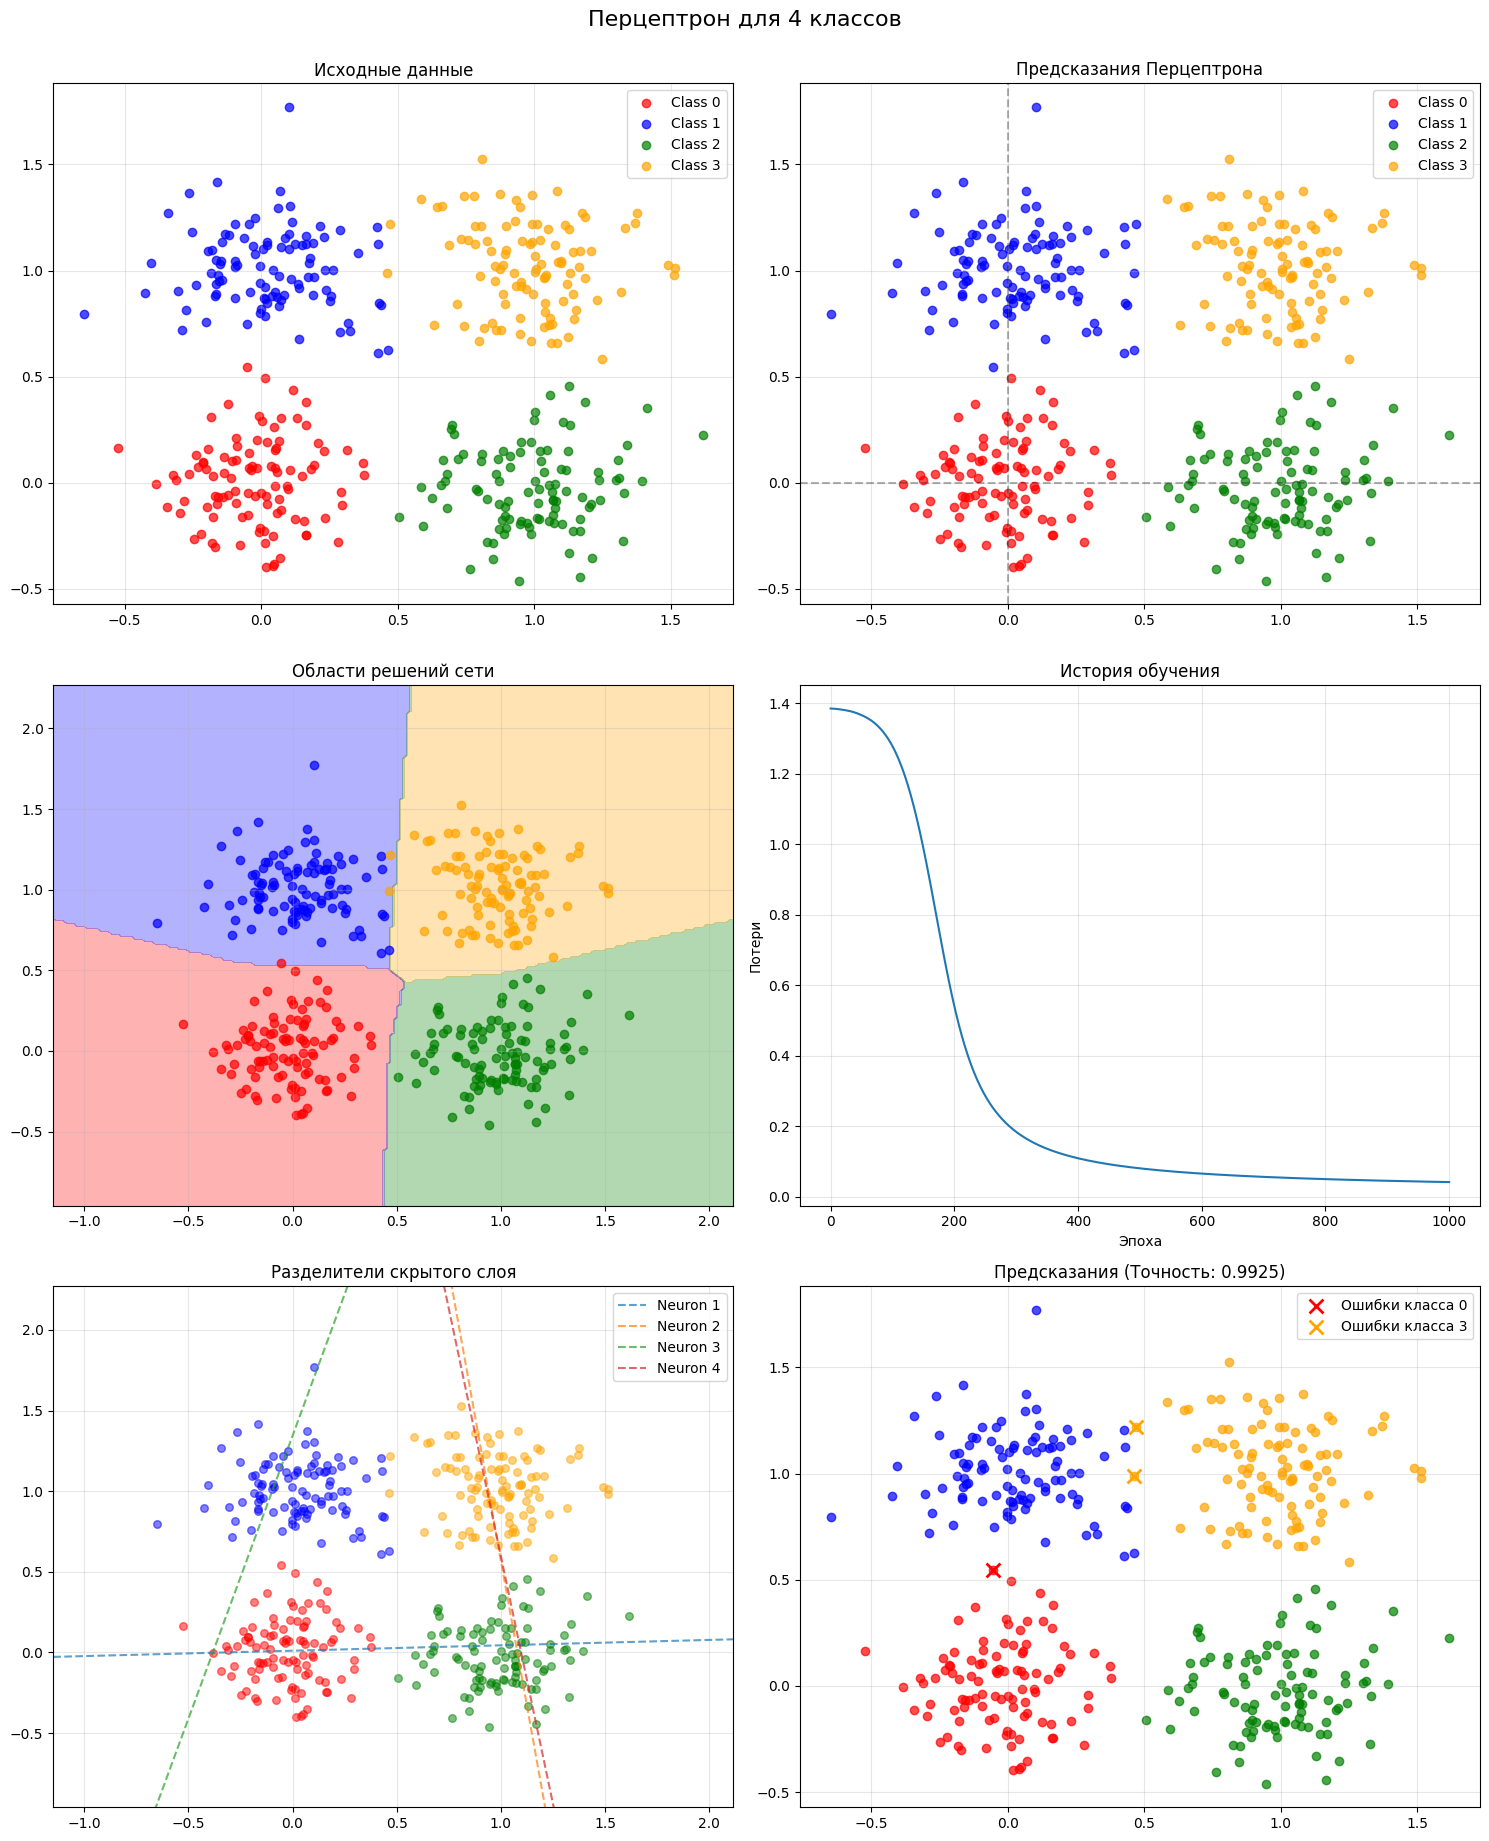

In [26]:
# Обучаем MLP
print("Обучение перцептрона ...")
# Создаем четыре множества точек
centr_1 = [0, 0] # Множество 0
centr_2 = [0, 1] # Множество 1
centr_3 = [1, 0] # Множество 2
centr_4 = [1, 1] # Множество 3

std = 0.2 # рассеяние классов от 0 до 1, чем выше тем классы более пересекаются

X, y = make_blobs(n_samples=400, centers=[centr_1, centr_2, centr_3, centr_4], n_features=2, 
                  random_state=42, cluster_std=std)

mlp = TwoLayerLinearPerceptron(hidden_units=4, learning_rate=0.1, max_epochs=2000)
mlp.fit(X, y)
final_accuracy = mlp.accuracy(X, y)
print(f"Финальная точность: {final_accuracy:.4f}")

# Визуализируем результаты
plot_mlp_results(mlp, X, y)